In [118]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

In [119]:
import os
import re
import shutil
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(torch.__version__)


2.8.0+cu129


In [120]:
from pathlib import Path
import sys

LANG_PAIR = "kor-eng"
DATA_FILE = "kor.txt"
DATASET_URL = "https://www.manythings.org/anki/kor-eng.zip"

IN_COLAB = "google.colab" in sys.modules or Path("/content").exists()
if IN_COLAB:
    base_dir = Path("/content/drive/MyDrive/AIFFEL/Deep_Dive/work/s2s_translation/datasets")
else:
    base_dir = Path.cwd() / "datasets"
base_dir.mkdir(parents=True, exist_ok=True)

dataset_dir = base_dir / LANG_PAIR
dataset_dir.mkdir(parents=True, exist_ok=True)

zip_path = dataset_dir / f"{LANG_PAIR}.zip"
if not zip_path.exists():
    local_zip_candidates = [
        Path.cwd() / f"{LANG_PAIR}.zip",
        Path.cwd() / "20251121" / f"{LANG_PAIR}.zip"
    ]
    copied = False
    for candidate in local_zip_candidates:
        if candidate.exists():
            shutil.copy(candidate, zip_path)
            print(f"로컬에 있던 {candidate.name}을(를) 재사용합니다.")
            copied = True
            break
    if not copied:
        print("데이터 다운로드 중...")
        urllib.request.urlretrieve(DATASET_URL, str(zip_path))
        print("다운로드 완료!")

path_to_file = dataset_dir / DATA_FILE
if not path_to_file.exists():
    print("압축 해제 중...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("압축 해제 완료!")

print("데이터셋 디렉토리:", sorted(p.name for p in dataset_dir.iterdir()))


데이터셋 디렉토리: ['_about.txt', 'kor-eng.zip', 'kor.txt']


In [121]:
column_names = ["eng", "kor", "attribution"]
df = (
    pd.read_csv(
        path_to_file,
        sep="	",
        names=column_names,
        quoting=3,
        engine="python"
    )
    .drop(columns=["attribution"])
)
df = df.dropna(subset=["eng", "kor"]).reset_index(drop=True)
print(f"총 문장 쌍 수: {len(df):,}")
df.head()


총 문장 쌍 수: 6,381


,eng,kor
0,Go.,가.
1,Hi.,안녕.
2,Run!,뛰어!
3,Run.,뛰어.
4,Who?,누구?


In [122]:
def preprocess_text(text):
    """
    영어/한국어 문장 전처리: 소문자화, 구두점 정규화, 특수문자 제거 등
    (구체적 토큰화는 SentencePiece에서 수행)
    """
    if pd.isna(text):
        return ""

    text = str(text)
    text = text.lower()
    text = re.sub(r'([.!?,])\1+', r'\1', text)
    text = re.sub(r"[^가-힣a-zA-Z0-9\s.!?,']", " ", text)
    text = re.sub(r'([.!?,])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

preprocess_korean = preprocess_text

print("슝~")


슝~


In [123]:
df["eng_proc"] = df["eng"].apply(preprocess_text)
df["kor_proc"] = df["kor"].apply(preprocess_korean)

punct_key = df["eng_proc"].str.replace(r"[.!?',]", "", regex=True).str.strip()
punct_dups = punct_key.duplicated().sum()
multi_targets = (df.groupby("eng_proc")["kor_proc"].nunique() > 1).sum()

lengths = pd.DataFrame({
    "eng_len": df["eng_proc"].str.split().str.len(),
    "kor_len": df["kor_proc"].str.split().str.len()
})
length_summary = lengths.describe().round(2)
length_summary.to_csv("sequence_length_stats.csv")

recommended_max_len = int(lengths.quantile(0.95).max())
MAX_SEQ_LEN = max(25, min(recommended_max_len, 60))

print(f"문장부호 제거 기준 중복 문장 수: {punct_dups:,}건")
print(f"영문 1문장에 대해 다수의 한국어 번역을 가진 문장 수: {multi_targets:,}건 (baseline 유지)")
print("시퀀스 길이 통계:", length_summary)
print(f"권장 max_len: {MAX_SEQ_LEN}")

df[["eng", "kor", "eng_proc", "kor_proc"]].head()


문장부호 제거 기준 중복 문장 수: 689건
영문 1문장에 대해 다수의 한국어 번역을 가진 문장 수: 601건 (baseline 유지)
시퀀스 길이 통계:        eng_len  kor_len
count  6381.00  6381.00
mean      6.57     5.24
std       2.94     2.27
min       2.00     1.00
25%       5.00     4.00
50%       6.00     5.00
75%       8.00     6.00
max     110.00    95.00
권장 max_len: 25


,eng,kor,eng_proc,kor_proc
0,Go.,가.,go .,가 .
1,Hi.,안녕.,hi .,안녕 .
2,Run!,뛰어!,run !,뛰어 !
3,Run.,뛰어.,run .,뛰어 .
4,Who?,누구?,who ?,누구 ?


In [124]:
df["eng_proc"].to_csv("eng_corpus.txt", index=False, header=False, encoding="utf-8")
df["kor_proc"].to_csv("kor_corpus.txt", index=False, header=False, encoding="utf-8")

print("파일 저장 완료: eng_corpus.txt, kor_corpus.txt")


파일 저장 완료: eng_corpus.txt, kor_corpus.txt


In [125]:
vocab_size = 3000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3


def train_sentencepiece(input_file, model_prefix, vocab_size):
    spm.SentencePieceTrainer.train(
        input=input_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id,
        hard_vocab_limit=False
    )
    sp = spm.SentencePieceProcessor()
    sp.load(f"{model_prefix}.model")
    print(f"{model_prefix}: 실제 vocab size = {len(sp)}")


train_sentencepiece("eng_corpus.txt", "encoder_spm", vocab_size)
train_sentencepiece("kor_corpus.txt", "decoder_spm", vocab_size)


encoder_spm: 실제 vocab size = 2396
decoder_spm: 실제 vocab size = 3000


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: eng_corpus.txt
  input_format: 
  model_prefix: encoder_spm
  model_type: UNIGRAM
  vocab_size: 3000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 0
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  d

In [126]:
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load("encoder_spm.model")

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load("decoder_spm.model")

True

In [127]:
df

,eng,kor,eng_proc,kor_proc
0,Go.,가.,go .,가 .
1,Hi.,안녕.,hi .,안녕 .
2,Run!,뛰어!,run !,뛰어 !
3,Run.,뛰어.,run .,뛰어 .
4,Who?,누구?,who ?,누구 ?
...,...,...,...,...
6376,I started a new blog. I'll do my best not to b...,난 블로그를 시작했어. 블로그를 초반에만 반짝 많이 하다가 관두는 사람처럼은 되지 ...,i started a new blog . i'll do my best not to ...,난 블로그를 시작했어 . 블로그를 초반에만 반짝 많이 하다가 관두는 사람처럼은 되지...
6377,I think it's a shame that some foreign languag...,몇몇 외국어 선생님이 한 번도 원어민과 공부해본 적도 없으면서 대학을 나올 수 있었...,i think it's a shame that some foreign languag...,몇몇 외국어 선생님이 한 번도 원어민과 공부해본 적도 없으면서 대학을 나올 수 있었...
6378,And the good news is that today the economy is...,"다음으로 좋은 소식은 오늘 경제가 재성장한다는 것입니다. 임금, 소득, 집값, 퇴직...",and the good news is that today the economy is...,"다음으로 좋은 소식은 오늘 경제가 재성장한다는 것입니다 . 임금 , 소득 , 집값 ..."
6379,If someone who doesn't know your background sa...,만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어...,if someone who doesn't know your background sa...,만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어...


In [128]:
SAMPLE_IDX = min(10000, len(df) - 1)
eng_sample = df.loc[SAMPLE_IDX, "eng_proc"]
kor_sample = df.loc[SAMPLE_IDX, "kor_proc"]
print(f"샘플 인덱스: {SAMPLE_IDX}")
print("ENG:", eng_sample)
print("KOR:", kor_sample)


샘플 인덱스: 6380
ENG: doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman .
KOR: 의심의 여지 없이 세상에는 어떤 남자이든 정확히 딱 알맞는 여자와 결혼하거나 그 반대의 상황이 존재하지 . 그런데 인간이 수백 명의 사람만 알고 지내는 사이가 될 기회를 갖는다고 생각해 보면 , 또 그 수백 명 중 열여 명 쯤 이하만 잘 알 수 있고 , 그리고 나서 그 열여 명 중에 한두 명만 친구가 될 수 있다면 , 그리고 또 만일 우리가 이 세상에 살고 있는 수백만 명의 사람들만 기억하고 있다면 , 딱 맞는 남자는 지구가 생겨난 이래로 딱 맞는 여자를 단 한번도 만난 적이 없을 수도 있을 거라는 사실을 쉽게 눈치챌 수 있을 거야 .


In [129]:
enc_token = encoder_tokenizer.encode(eng_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
enc_token

[1,
 1537,
 574,
 55,
 743,
 5,
 27,
 46,
 5,
 244,
 135,
 1757,
 136,
 42,
 15,
 8,
 174,
 129,
 758,
 53,
 76,
 226,
 19,
 125,
 10,
 1502,
 21,
 8,
 74,
 518,
 139,
 1266,
 5,
 87,
 155,
 127,
 11,
 1375,
 20,
 14,
 312,
 457,
 66,
 15,
 623,
 1558,
 1281,
 21,
 36,
 457,
 968,
 2012,
 243,
 373,
 63,
 59,
 42,
 14,
 124,
 362,
 1005,
 180,
 8,
 28,
 8,
 74,
 130,
 36,
 15,
 124,
 362,
 1005,
 20,
 55,
 40,
 155,
 14,
 1171,
 19,
 268,
 848,
 77,
 24,
 29,
 49,
 5,
 27,
 12,
 1992,
 42,
 8,
 28,
 8,
 74,
 130,
 36,
 15,
 1171,
 19,
 8,
 28,
 121,
 268,
 72,
 301,
 311,
 71,
 332,
 8,
 28,
 31,
 100,
 8,
 1235,
 42,
 26,
 157,
 19,
 8,
 28,
 127,
 38,
 313,
 15,
 879,
 36,
 1661,
 5,
 77,
 1749,
 791,
 46,
 5,
 244,
 135,
 8,
 28,
 20,
 610,
 733,
 21,
 8,
 28,
 826,
 15,
 658,
 208,
 32,
 1434,
 18,
 8,
 28,
 15,
 8,
 174,
 125,
 66,
 8,
 137,
 246,
 12,
 400,
 15,
 8,
 174,
 129,
 758,
 4,
 2]

In [130]:
enc_decoding = encoder_tokenizer.decode(enc_token)
enc_decoding

'doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman .'

In [131]:
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data.iloc[idx]['eng_proc']
        trg_text = self.data.iloc[idx]['kor_proc']

        src_ids = self.encoder_tokenizer.encode(src_text)
        trg_ids = self.decoder_tokenizer.encode(trg_text)

        src_ids = src_ids[:self.max_len]

        trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
        trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]

        src_ids = src_ids + [self.pad_id] * (self.max_len - len(src_ids))
        trg_input = trg_input + [self.pad_id] * (self.max_len - len(trg_input))
        trg_label = trg_label + [self.pad_id] * (self.max_len - len(trg_label))

        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)


In [132]:
train_ratio = 0.8
MAX_LEN = int(globals().get("MAX_SEQ_LEN", 40))
BATCH_SIZE = 1024  # 성능 최적화: 64 → 1024

train_data = df.sample(frac=train_ratio, random_state=42)
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validataion_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)
validation_loader = DataLoader(
    validataion_data, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)


In [133]:
for src, trg_input, trg_label in train_loader:
    print(src.shape, trg_input.shape, trg_label.shape)
    break

torch.Size([1024, 25]) torch.Size([1024, 25]) torch.Size([1024, 25])


In [134]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (src_len, batch_size, hidden_dim)

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, src_len, hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_len, hidden_dim)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # (batch_size, src_len, hidden_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, src_len)

        return nn.functional.softmax(attention, dim=1)  # (batch_size, src_len)

In [135]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim)

    def forward(self, src):
        # src : (src_len, batch_size)
        embedded = self.embedding(src)  # embedded : (src_len, batch_size, emb_dim)
        outputs, hidden = self.rnn(embedded)  # outputs : (src_len, batch_size, hidden_dim)

        return outputs, hidden

In [136]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Decoder RNN에는 embedding만 입력
        self.rnn = nn.GRU(emb_dim, hidden_dim)
        # 출력층에는 hidden state와 attention value가 결합되어 입력
        self.fc_out = nn.Linear(hidden_dim + hidden_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        # input : (batch_size,)
        # hidden : (batch_size, hidden_dim)
        # encoder_outputs : (src_len, batch_size, hidden_dim)
        input = input.unsqueeze(0)  # input : (1, batch_size)
        embedded = self.embedding(input)  # embedded : (1, batch_size, emb_dim)

        # attention distribution을 계산합니다. decoder의 이전 hidden state, s_{t-1}와 encoder의 H가 입력됩니다.
        a = self.attention(hidden[-1], encoder_outputs)  # a : (batch_size, src_len)

        # H에 가중치를 부여해 attention value(Context vector) 계산
        a = a.unsqueeze(1)  # a : (batch_size, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs : (batch_size, src_len, hidden_dim)
        context = torch.bmm(a, encoder_outputs)  # context : (batch_size, 1, hidden_dim)
        context = context.permute(1, 0, 2)  # context : (1, batch_size, hidden_dim)

        output, hidden = self.rnn(embedded, hidden)

        # 출력층에서는 현재 hidden state와 context vector를 결합하여 예측값 생성
        output = output.squeeze(0)  # output : (batch_size, hidden_dim)
        context = context.squeeze(0)  # context : (batch_size, hidden_dim)
        prediction = self.fc_out(torch.cat((output, context), dim=1))  # (batch_size, output_dim)

        return prediction, hidden, a.squeeze(1)

In [137]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, max_len=30, bos_id = 1, eos_id=2):
        # 학습 모드에서는 trg_len 사용, 추론 모드에서는 max_len까지 동적 생성
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # 조기 종료를 위해 tensor가 아닌 리스트 사용
        outputs = []

        # 시각화를 위해 attention 저장
        attentions = []

        # 인코더를 통해 context 생성
        encoder_outputs, hidden = self.encoder(src)

        if trg is not None:
            for t in range(0, trg.shape[0]):
                input = trg[t]
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))

        else:
		    # inference에서는 target(정답)이 없기 때문에 sos_token을 생성해줍니다.
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden,  encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                top1 = output.argmax(1)
                input = top1

                # 조기 종료 조건
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)  # (trg_len, batch_size, output_dim)
        attentions = torch.cat(attentions, dim=0)  # (trg_len, batch_size, src_len)

        return outputs, attentions

In [138]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

input_dim = len(encoder_tokenizer)
output_dim = len(decoder_tokenizer)
emb_dim = 256
hid_dim = 512

In [139]:
encoder = Encoder(input_dim, emb_dim, hid_dim).to(device)
attention = BahdanauAttention(hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

In [140]:
print(model)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(2396, 256)
    (rnn): GRU(256, 512)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=512, out_features=512, bias=True)
      (W2): Linear(in_features=512, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
    (fc_out): Linear(in_features=1024, out_features=3000, bias=True)
  )
)


In [141]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

print("슝~")

슝~


In [142]:
def train_step(model, data_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", leave=True)

    for src, trg_input, trg_label in progress_bar:
        # ✅ 차원 변환: (batch, seq) → (seq, batch)
        src = src.transpose(0, 1).to(device)
        trg_input = trg_input.transpose(0, 1).to(device)
        trg_label = trg_label.transpose(0, 1).to(device)
        
        optimizer.zero_grad()

        outputs,_ = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.reshape(-1, outputs.shape[-1])
        trg_label = trg_label.reshape(-1)

        loss = criterion(outputs, trg_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(data_loader)

print("슝~")


슝~


In [143]:
%%time

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}')

Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  8.53it/s, loss=5.93]


Epoch 1/10, Train Loss: 7.0759


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 10.19it/s, loss=5.25]


Epoch 2/10, Train Loss: 5.4221


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 10.75it/s, loss=5]   


Epoch 3/10, Train Loss: 5.0559


Epoch 4: 100%|██████████| 5/5 [00:00<00:00,  9.96it/s, loss=4.8] 


Epoch 4/10, Train Loss: 4.8338


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 10.04it/s, loss=4.56]


Epoch 5/10, Train Loss: 4.6305


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 10.08it/s, loss=4.38]


Epoch 6/10, Train Loss: 4.4249


Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 10.10it/s, loss=4.2] 


Epoch 7/10, Train Loss: 4.2327


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 10.13it/s, loss=4.04]


Epoch 8/10, Train Loss: 4.0519


Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 10.06it/s, loss=3.82]


Epoch 9/10, Train Loss: 3.8782


Epoch 10: 100%|██████████| 5/5 [00:00<00:00, 10.12it/s, loss=3.67]

Epoch 10/10, Train Loss: 3.7111
CPU times: user 4.06 s, sys: 265 ms, total: 4.33 s
Wall time: 5.06 s


In [144]:
def eval_step(model, data_loader, optimizer, criterion):
    model.eval()
    total_loss = 0

    for src, trg_input, trg_label in data_loader:
        # ✅ 차원 변환: (batch, seq) → (seq, batch)
        src = src.transpose(0, 1).to(device)
        trg_input = trg_input.transpose(0, 1).to(device)
        trg_label = trg_label.transpose(0, 1).to(device)

        with torch.no_grad():
            outputs, _ = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.reshape(-1, outputs.shape[-1])
        trg_label = trg_label.reshape(-1)

        loss = criterion(outputs, trg_label)

        total_loss += loss.item()

    return total_loss / len(data_loader)

print("슝~")

슝~


In [145]:
%%time

EPOCHS = 20

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    valid_loss = eval_step(model, validation_loader, optimizer, criterion)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 10.14it/s, loss=3.51]


Epoch 1/20, Train Loss: 3.5497, Validation Loss: 4.3027


Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  7.87it/s, loss=3.37]



Epoch 2/20, Train Loss: 3.3936, Validation Loss: 4.2373


Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  9.67it/s, loss=3.21]



Epoch 3/20, Train Loss: 3.2414, Validation Loss: 4.1741


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 10.12it/s, loss=3.09]



Epoch 4/20, Train Loss: 3.0926, Validation Loss: 4.1175


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 10.18it/s, loss=2.92]



Epoch 5/20, Train Loss: 2.9497, Validation Loss: 4.0746


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 10.10it/s, loss=2.77]



Epoch 6/20, Train Loss: 2.8068, Validation Loss: 4.0274


Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 10.15it/s, loss=2.66]



Epoch 7/20, Train Loss: 2.6678, Validation Loss: 3.9834


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 10.11it/s, loss=2.48]



Epoch 8/20, Train Loss: 2.5333, Validation Loss: 3.9487


Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 10.21it/s, loss=2.38]



Epoch 9/20, Train Loss: 2.3987, Validation Loss: 3.9176


Epoch 10: 100%|██████████| 5/5 [00:00<00:00, 10.21it/s, loss=2.25]



Epoch 10/20, Train Loss: 2.2684, Validation Loss: 3.8845


Epoch 11: 100%|██████████| 5/5 [00:00<00:00, 10.24it/s, loss=2.11]



Epoch 11/20, Train Loss: 2.1420, Validation Loss: 3.8709


Epoch 12: 100%|██████████| 5/5 [00:00<00:00, 10.25it/s, loss=2.01]



Epoch 12/20, Train Loss: 2.0185, Validation Loss: 3.8356


Epoch 13: 100%|██████████| 5/5 [00:00<00:00, 10.20it/s, loss=1.9] 



Epoch 13/20, Train Loss: 1.8970, Validation Loss: 3.8156


Epoch 14: 100%|██████████| 5/5 [00:00<00:00, 11.09it/s, loss=1.75]



Epoch 14/20, Train Loss: 1.7783, Validation Loss: 3.7972


Epoch 15: 100%|██████████| 5/5 [00:00<00:00, 11.22it/s, loss=1.63]



Epoch 15/20, Train Loss: 1.6645, Validation Loss: 3.7876


Epoch 16: 100%|██████████| 5/5 [00:00<00:00, 11.22it/s, loss=1.55]



Epoch 16/20, Train Loss: 1.5535, Validation Loss: 3.7728


Epoch 17: 100%|██████████| 5/5 [00:00<00:00, 10.84it/s, loss=1.45]



Epoch 17/20, Train Loss: 1.4475, Validation Loss: 3.7584


Epoch 18: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s, loss=1.31]



Epoch 18/20, Train Loss: 1.3444, Validation Loss: 3.7482


Epoch 19: 100%|██████████| 5/5 [00:00<00:00, 11.25it/s, loss=1.26]



Epoch 19/20, Train Loss: 1.2470, Validation Loss: 3.7419


Epoch 20: 100%|██████████| 5/5 [00:00<00:00, 10.01it/s, loss=1.15]



Epoch 20/20, Train Loss: 1.1536, Validation Loss: 3.7349
CPU times: user 9.02 s, sys: 922 ms, total: 9.94 s
Wall time: 13.2 s


In [146]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_text(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    pred_ids = outputs.argmax(2).squeeze(1).tolist()
    eos_token = decoder_tokenizer.eos_id()
    if eos_token in pred_ids:
        pred_ids = pred_ids[:pred_ids.index(eos_token)]

    result = decoder_tokenizer.decode(pred_ids).replace('▁', ' ').strip()

    return result, sentence, attentions.squeeze(1).cpu().numpy()


In [147]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [148]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print(f'Input (ENG): {sentence}')
    print(f'Predicted translation (KOR): {result}')

    src_tokens = sentence.split()
    trg_tokens = result.split()
    attention = attention[:len(trg_tokens), :len(src_tokens)]

    if len(src_tokens) and len(trg_tokens):
        plot_attention(attention, src_tokens, trg_tokens)


Input (ENG): may i help you ?
Predicted translation (KOR): 제가 도와드릴까요 ?


/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/mai

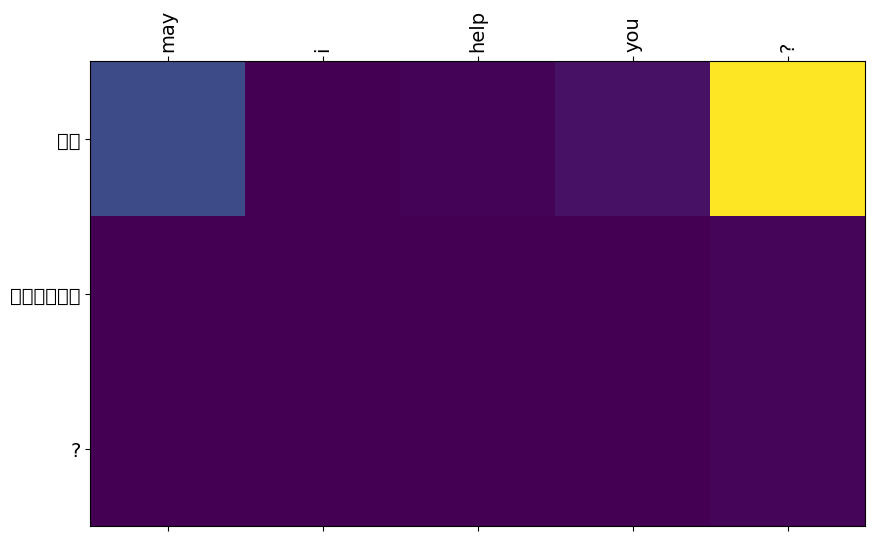

In [150]:
translate("May I help you?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input (ENG): there is a cat
Predicted translation (KOR): 멋져가 있어요 .


/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47691 (\N{HANGUL SYLLABLE MEOS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51256 (\N{HANGUL SYLLABLE JYEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51080 (\N{HANGUL SYLLABLE ISS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv

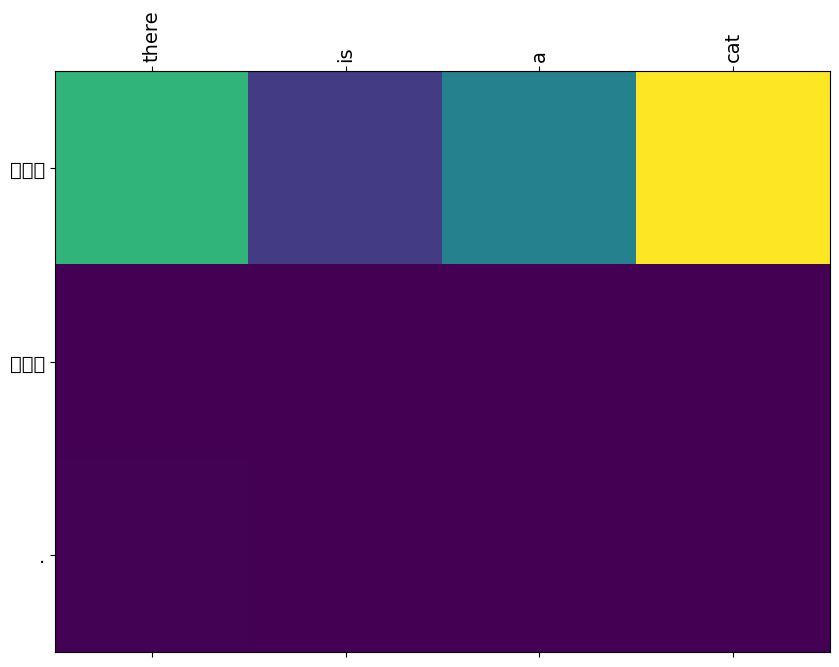

In [152]:
translate("There is a cat", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input (ENG): can i have some coffee ?
Predicted translation (KOR): 커피 한 잔 더 마시겠습니까 ?


/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45908 (\N{HANGUL SYLLABLE DEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/venv/

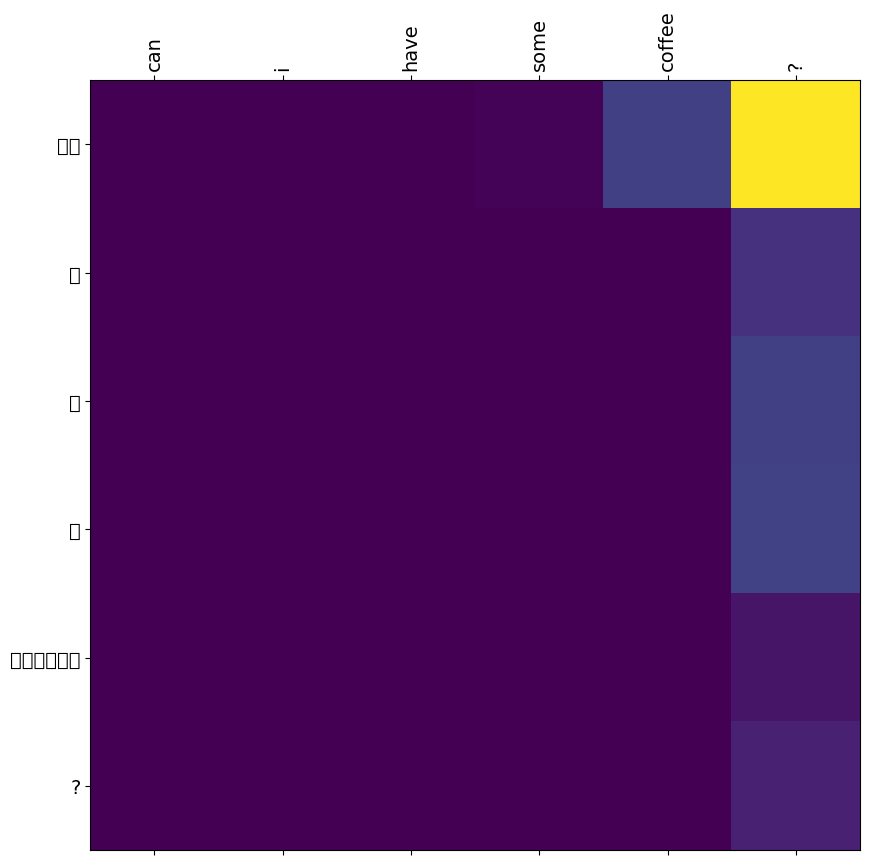

In [151]:
# 실행 예제
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)